In [90]:
# !pip install vaderSentiment
# !pip install spacy
import nltk
from nltk.corpus import stopwords
import pandas as pd
import pickle
import numpy as np
from nltk import word_tokenize, FreqDist
import string
from os import path
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer as sa
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return (stopwords_removed)

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...','.' ,'``','1','2','3','4','5','6'
                   ,'7','8','9',"'s","'",'’',"n't","'ve","'m"]

sp = spacy.load('en')

with open('userratingsDF.pickle', 'rb') as f:
    dfr = pickle.load(f)
    
with open('CategoricalItemDF.pickle', 'rb') as f:
    full = pickle.load(f)

# with open('_SENT&RATINGDF.pickle', 'rb') as f:
#     df1 = pickle.load(f)

In [91]:
corpus1=dfr['content']
corpus=nltk.Text(dfr['content'])

In [92]:
full.sort_values('url',inplace=True)

In [93]:
full.head()

,price,prodName,rating,url,age,darkcircles,acne,dry,redness,sensitive,...,moisturizer,balm,oil,mask,peel,lip,eye,supplement,tool,brand
771,26.60,Anthony Continuous Moisture Eye Cream (21gm),5.0,10236357,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Iluminage
418,12.00,DuWop Reverse Eyeliner .14oz,3.4,10302491,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Natura Bissé
1350,44.00,Jurlique Balancing Day Care Cream,4.0,10305907,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
941,22.13,Elizabeth Arden Ceramide Purifying Toner 200ml,5.0,10305956,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Lancer Skincare
1746,18.00,"Caudalie Supersize Grape Water (200ml, Worth $27)",5.0,10306437,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,NaN


In [94]:
dfr.head()

,content,date,rating,title,url,user
0,this product has changed my problematic skin. ...,2019-08-08,5,Amazing,11174178,becky c
1,i absolutely love this product. it's one of th...,2019-05-05,5,Amazing,11174178,jess
2,i was really hoping this would work for since ...,2019-04-12,5,Awesome,11174178,lisa
3,not sure why everyone doesn't use this amazing...,2018-12-13,5,Extraordinary,11174178,stella2
4,i've struggled with breakouts my entire life a...,2018-12-01,5,Actually Works!,11174178,carli


# Tokenizing and Removing Stop Words & Lemmatizing

In [95]:
#processed_data is a list of lists. each smaller list represents a tokenized
#review where stop words have been removed
processed_data = list(map(process_article, corpus))

In [96]:
#articles_contact is one list containing all words in the tokenized 
#corpus with stopwords removed, can be repeated, not all words unique
articles_concat = []
for article in processed_data:
    articles_concat += article

In [97]:
lemcontent=[]
for review in processed_data:
    words=[]
    sentence=sp(' '.join(review))
    for word in sentence:
        words.append(word.lemma_)
    if words not in lemcontent:
        lemcontent.append(words)

In [98]:
lemwords=[]
words=' '.join(articles_concat)
words=sp(words)
for word in words:
    lemwords.append(word.lemma_)

In [99]:
lemmas_freqdist = FreqDist(lemwords)
# lemmas_freqdist.most_common(200)

In [100]:
maximum_frequncy = max(lemmas_freqdist.values())
weightedic={}
for word in lemmas_freqdist.keys():
    weightedic[word] = (lemmas_freqdist[word]/maximum_frequncy)

In [101]:
sentence_scores = {}
for sent in list(dfr.content):
    for word in sent.split(' '):
        if word in weightedic.keys():
            if len(sent.split(' ')) < 30:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = weightedic[word]
                else:
                    sentence_scores[sent] += weightedic[word]

In [102]:
sent_scores=[]
for s in list(dfr.content):
    for sent,score in zip(sentence_scores.keys(),sentence_scores.values()):
        if sent==s:
            sent_scores.append({'sentence':sent,'score':score})
sentscoredf=pd.DataFrame(sent_scores)

In [103]:
sentscoredf

,score,sentence
0,7.810130,amazing product! clears up congested skin but ...
1,1.576707,nothing has shrunken my pores like this. and i...
2,2.402985,good product! i'll continue to buy it .
3,17.473452,i apply this product twice a day to calm my sk...
4,1.190360,"used it for months, didn't do anything to fade..."
5,0.537803,phyto corrective gel works nicely on any infla...
6,2.690727,this serum dramatically decreased redness in m...
7,9.347932,i've been using this product for a couple of w...
8,5.954245,"the smell is ..... not so nice, but the produc..."
9,3.103010,love this product. i’ve tried others this is o...


In [104]:
articles_freqdist = FreqDist(articles_concat)
# articles_freqdist.most_common(200)

## Getting Sentiment Scores

In [105]:
dfr.sort_values('url',inplace=True)

In [144]:
new=[]
for p,u,t,us in zip(processed_data,dfr.url,dfr.title,dfr.user):
    new.append({'url':u,'content':' '.join(p),'title':t,'user':us})
newdf=pd.DataFrame(new)

In [146]:
# newdf.drop_duplicates(inplace=True)
len(newdf)

1685

In [147]:
analyzer = SentimentIntensityAnalyzer()

In [148]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
#     print("{:-<40} {}".format(sentence, str(score)))
    return score['pos']

In [150]:
sentiments=[]
for (ur,t,c,u) in zip(newdf.url,newdf.title,newdf.content,newdf.user):
    sentiments.append({'url':ur,'tsentiment':sentiment_analyzer_scores(t),'csentiment':sentiment_analyzer_scores(c),'user':u})
sentimentsdf=pd.DataFrame(sentiments)

In [151]:
sentimentsdf.sort_values('url',inplace=True)
sentimentsdf.drop_duplicates(inplace=True)

In [152]:
sentimentsdf

,csentiment,tsentiment,url,user
0,0.213,0.000,10236357,kimber
1,0.325,0.677,10236357,george
2,0.425,0.800,10236357,mike
3,0.320,0.388,10236357,adrian
4,0.249,0.672,10236357,westtexas
5,0.259,1.000,10305907,marvymds
6,0.503,0.506,10305907,trixie
7,0.326,0.818,10305956,sandi
8,0.248,0.694,10305956,"cara bryant, newman, western australia"
9,0.000,0.000,10305956,confused


In [153]:
avg_sent_by_url=sentimentsdf.groupby('url').mean()
avg_sent_by_url.sort_values('url',inplace=True)

In [154]:
avgsent=[]
for (au,c,t) in zip(avg_sent_by_url.index,avg_sent_by_url['csentiment'],avg_sent_by_url['tsentiment']):
    for u in dfr.url:
        if u==au:
            avgsent.append({'url':au,'avg_content_sent':c,'avg_title_sent':t})
avgsentdf=pd.DataFrame(avgsent)

In [155]:
avgsentdf.drop_duplicates(inplace=True)
avgsentdf.reset_index(inplace=True)
# avgsentdf.drop(columns=['content_sent','title_sent'],inplace=True)
len(avgsentdf)

514

In [156]:
avgt=[]
avgc=[]
df1=dfr
for u in df1.url:
    for (ua,t,c) in zip(avgsentdf.url,avgsentdf.avg_title_sent,avgsentdf.avg_content_sent):
        if u==ua:
#             avgt.append({'url':u,'avg_title_sent':t,'avg_content_sent':c})
            avgt.append(t)
            avgc.append(c)

In [140]:
sentimentsdf.drop_duplicates()

,csentiment,tsentiment,url,user
0,0.213,0.000,10236357,kimber
1,0.325,0.677,10236357,george
2,0.425,0.800,10236357,mike
3,0.320,0.388,10236357,adrian
4,0.249,0.672,10236357,westtexas
5,0.259,1.000,10305907,marvymds
6,0.503,0.506,10305907,trixie
7,0.326,0.818,10305956,sandi
8,0.248,0.694,10305956,"cara bryant, newman, western australia"
9,0.000,0.000,10305956,confused


In [157]:
len(list(sentimentsdf['csentiment']))

1685

In [158]:
len(df1)

1685

In [159]:
df1=dfr
df1.drop_duplicates(inplace=True)
df1['average_content_sentiment']=avgc
df1['average_title_sentiment']=avgt
df1['content_sentiment']=list(sentimentsdf['csentiment'])
df1['title_sentiment']=list(sentimentsdf['tsentiment'])
# df1['processed_content']=lemcontent

In [160]:
df1.reset_index(inplace=True)
df1.drop(columns='index',inplace=True)
df1 # YES!

,content,date,rating,title,url,user,average_content_sentiment,average_title_sentiment,content_sentiment,title_sentiment
0,i have used this product for 4 years. easy to ...,2012-01-30,5,Years,10236357,kimber,0.30640,0.507400,0.213,0.000
1,"the best eye creme ever tried, it delivers res...",2005-09-22,5,simply the best,10236357,george,0.30640,0.507400,0.325,0.677
2,the cream was easy to use and did not feel gre...,2007-12-19,5,Great Results. Loved It.,10236357,mike,0.30640,0.507400,0.425,0.800
3,"i didn't have any wrinkles around my eyes, but...",2010-02-05,5,It's worth the money,10236357,adrian,0.30640,0.507400,0.320,0.388
4,it keeps your eye area moisturizer without bei...,2014-04-21,5,Great eye product,10236357,westtexas,0.30640,0.507400,0.249,0.672
5,i am surprised that jurlique did not name this...,2012-09-27,5,Comforting,10305907,marvymds,0.38100,0.753000,0.259,1.000
6,it seems like such a small tube but fortunatel...,2014-03-10,4,Mattifying; Great for combination skin,10305907,trixie,0.38100,0.753000,0.503,0.506
7,this is the best toner i have ever used! it is...,2006-08-04,5,Love it!,10305956,sandi,0.24850,0.378000,0.326,0.818
8,"this was my first purchse with skinstore, and ...",2008-01-01,5,"Bright, Beautiful and Bearly there",10305956,"cara bryant, newman, western australia",0.24850,0.378000,0.248,0.694
9,just read alcohol is a terrible ingrediant for...,2008-03-01,1,Alcohol?!,10305956,confused,0.24850,0.378000,0.000,0.000


In [162]:
df1.sort_values('user')

,content,date,rating,title,url,user,average_content_sentiment,average_title_sentiment,content_sentiment,title_sentiment
712,i have been using this product for several yea...,2011-12-09,5,Good stuff!,11289064,000000,0.389333,0.523000,0.500,0.761
1260,after researching the juice beauty line i deci...,2011-05-16,2,Not so much...,11294885,1908,0.233000,0.458200,0.276,0.000
546,"i always hated my oily skin, but now, in my 60...",2012-11-08,5,Helps with acne and wrinkles,11287696,2,0.321000,0.131333,0.221,0.000
256,i have purchased this a couple of times before...,2013-05-27,5,Must Keep On Hand At All Times,11054488,24fan,0.322333,0.468333,0.190,0.412
1128,i have used many products and this is at the t...,2014-07-22,5,great product,11291061,4strong,0.309857,0.487000,0.355,1.000
112,after buying about everything on the market fo...,2010-06-01,5,Life Saver,10543756,61bks,0.367700,0.574200,0.253,0.556
952,i tried this exfoliating cleanser in a travel ...,2015-08-03,5,favorite cleanser,11289657,7asm0,0.248250,0.578750,0.169,0.804
646,i absolutely love this eye cream. it hydrates...,2016-06-11,5,AMAZING for eyes and lips!,11288446,a girl,0.420000,0.547000,0.420,0.547
980,my face feels good after application,2006-10-13,5,Refreshing,11289674,a way,0.380250,0.397875,0.427,0.800
239,this mask is amazing! skin will become smooth ...,2016-06-09,5,best mask ever,10941238,aaron,0.256750,0.692000,0.282,0.677


In [161]:
with open('_SENT&RATINGDF.pickle', 'wb') as f:
    pickle.dump(df1, f, pickle.HIGHEST_PROTOCOL)

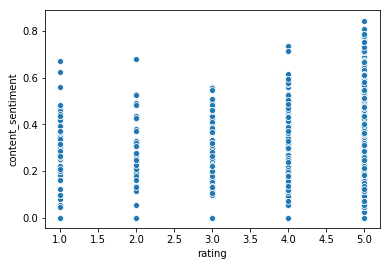

In [163]:
import seaborn as sns
sns.scatterplot(x='rating',y='content_sentiment',data=df1)

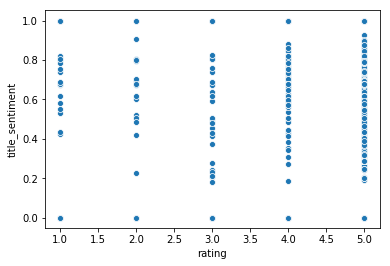

In [164]:
sns.scatterplot(x='rating',y='title_sentiment',data=df1)

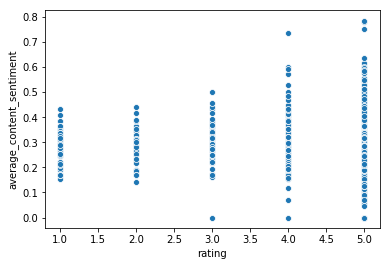

In [165]:
sns.scatterplot(x='rating',y='average_content_sentiment',data=df1)

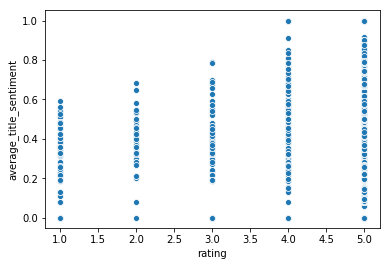

In [166]:
sns.scatterplot(x='rating',y='average_title_sentiment',data=df1)

# Trying TFIDF: not sure why we would need this

In [160]:
# tfidf = vectorizer.fit_transform(corpus)

In [162]:
# tfidf.shape

(3258, 5274)

In [164]:
# non_zero_cols = tfidf.nnz / float(tfidf.shape[0])
# print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

# percent_sparse = 1 - (non_zero_cols / float(tfidf.shape[1]))
# print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 42.258747697974215
Percentage of columns containing 0: 0.9919873440087269


# Some NLTK EDA

In [167]:
tokens=[]
for r in dfr.content:
    tokens.append(nltk.word_tokenize(r.lower()))

In [168]:
alltokensr=[]
for t in tokens:
    string=[]
    for word in t:
        if word not in stopwords_list:
            string.append(word)
    alltokensr.append(string)

In [169]:
dfr['tokens']=alltokensr

In [170]:
allvocab=set()
for comment in alltokensr:
    allvocab.update(comment)
len(allvocab)

5869

In [171]:
articles_concat = []
for article in alltokensr:
    articles_concat += article

In [172]:
from wordcloud import WordCloud

In [173]:
def plot_wordcloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

## Whole Corpus Word Cloud

In [174]:
wordcloud = WordCloud().generate(str(corpus[7:]))

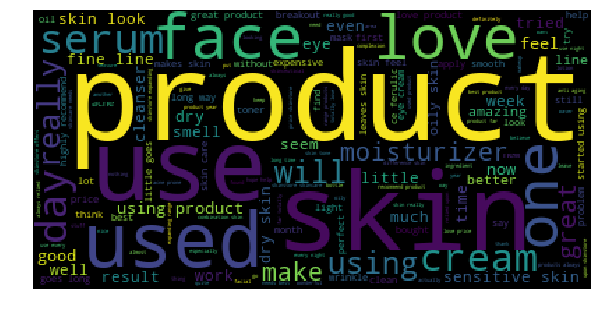

In [175]:
plot_wordcloud(wordcloud)

## Processed Corpus Word Cloud 

In [176]:
lemwords=[]
words=' '.join(articles_concat)
words=sp(words)
for word in words:
    lemwords.append(word.lemma_)

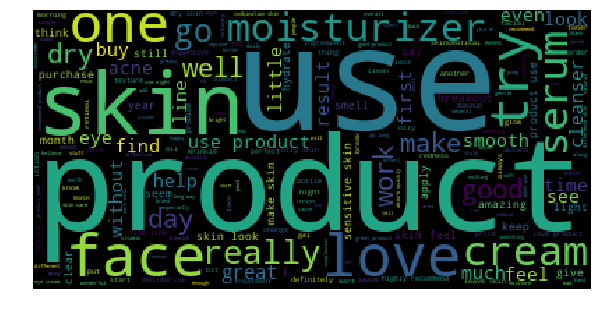

In [177]:
al=' '.join(lemwords)
wordcloud = WordCloud().generate(al)
plot_wordcloud(wordcloud)